In [2]:
%matplotlib inline
import scipy as scp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16, 9)})
import thinkbayes2

# Exercise 7.1

If we assume the waiting time to be modeled by the random variable $W \in \{0, 1, \dots , 20 \} $ that is uniformly distributed, we need to take the observer bias into account, i.e. the probability of seeing the an interval gets more likely the longer the interval is. So we need to multiply the probability for the prior with the interval length:

$ P(observed W=m) \propto m \cdot P(W=m) $

So if we model the bus waiting time a less reliable process where we could see the bus arrival being distributed exponentially: 

$ P(W=m) = \lambda \exp( - \lambda t ) $ 

And finally the waiting time is just the mixture of all uniform waiting time distributions. The exponential waiting time distributions is just the wait to combine the uniform distributions.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


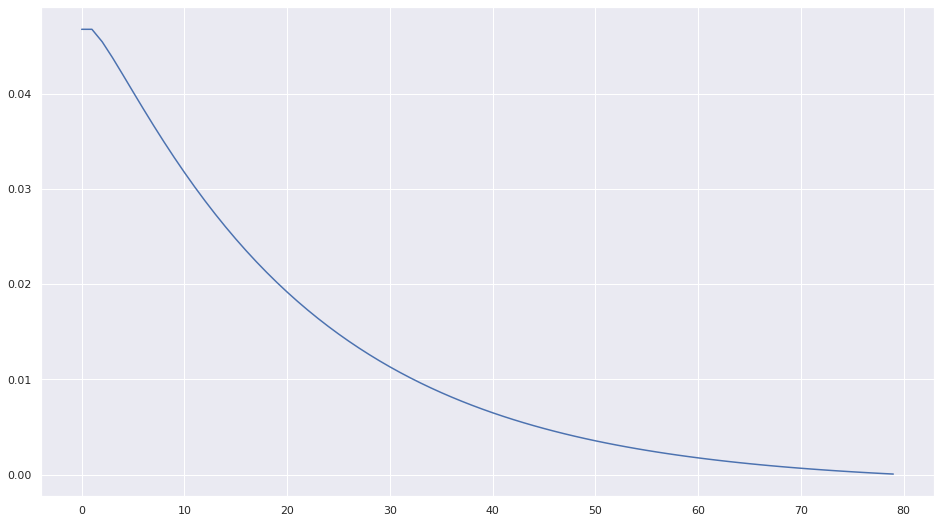

In [9]:
import math

bus_arrival_rate = 1. / 20.
hypotheses = list(range(80))
print(hypotheses)

# defining the meta distribution
metapmf = thinkbayes2.Pmf()
for waiting_time in hypotheses:
    pure_wait_time_prob = bus_arrival_rate * math.exp(-1. * bus_arrival_rate * waiting_time)
    metapmf.Set(
        thinkbayes2.Pmf(list(range(waiting_time + 1))),
        pure_wait_time_prob * waiting_time
    )
mixture = thinkbayes2.MakeMixture(metapmf)
mixture.Normalize()
sns.lineplot(*zip(*mixture.SortedItems()))

# Exercise 7.2

We are looking for the posterior distribution:

$ P( D | H) = \frac { P( D | H ) P(H) } { P(D) } $


In that case $H$ is the amount of time $t$ since the last bus arrived.

So the prior for the waiting time is the mixture of uniform distributions from the previous exercise:

$ P(H = x) = \sum_{t = 0}^T \lambda_b  \exp( - \lambda_b t ) \frac 1 t \cdot 1_{x \leq t} $

where $ \lambda_b $ is the bus arrival rate within one minute (we assume $ \frac 1 {20} $ here) and T some upper threshold. We can do that as both the waiting time as well as the time elapsed since the last bus are both uniformly distributed. In 7.1 we came up with the waiting time and now we are interested in the elapsed time.

Now we need the likelyhood:

$ P(D | H )$ 

$ D $ in this case is the number of passengers waiting for the bus (customers) $C $ equals $ 3 $. 

$ P(D | H ) = P(C = 3 | H=t)$ 

The the likelyhood of observing $k =3$ waiting passengers with passenger arrival rate $\lambda_p $ is:

$ P(D | H ) = \frac {(\lambda_p * t)^3} {3!} \exp( \lambda_p t ) $ 

where $\lambda_b $ should be the arrival rate for the bus to come.

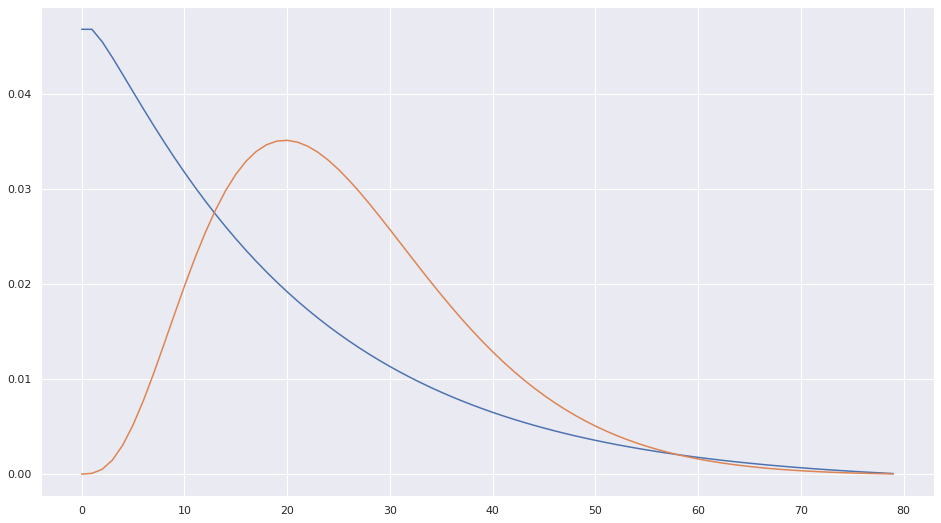

In [15]:
import math

class BusWaitingTime(thinkbayes2.Suite):
    def __init__(self, prior, passenger_rate):
        super().__init__()
        for hypo, prob in prior.SortedItems():
            self.Set(hypo, prob)
        self.Normalize()

        self.passenger_rate = passenger_rate    
        
    def Likelihood(self, data, hypo):
        return (self.passenger_rate * hypo) ** data / math.factorial(data) * math.exp(- self.passenger_rate * hypo)
    

bob_bus = BusWaitingTime(prior=mixture, passenger_rate=1 / 10)

sns.lineplot(*zip(*bob_bus.SortedItems()))

bob_bus.Update(3)
sns.lineplot(*zip(*bob_bus.SortedItems()))

As you can observe here we get a combination of the prior that looks really exponential and the Poisson distribution. For this plot we assume $ \lambda = \frac 1 {10} $. In case we would just take the likelihood into account our best guess would be $ \frac 3 {\frac 1 {10}} = 30 $.

# Exercise 7.3

As the ecologist puts up $ 100 $ different traps his assumption is that there are no more than $100$ insects per time interval. Moreover we assume that all of these assumptions for the fly rate $\lambda_f $ are equally likely.

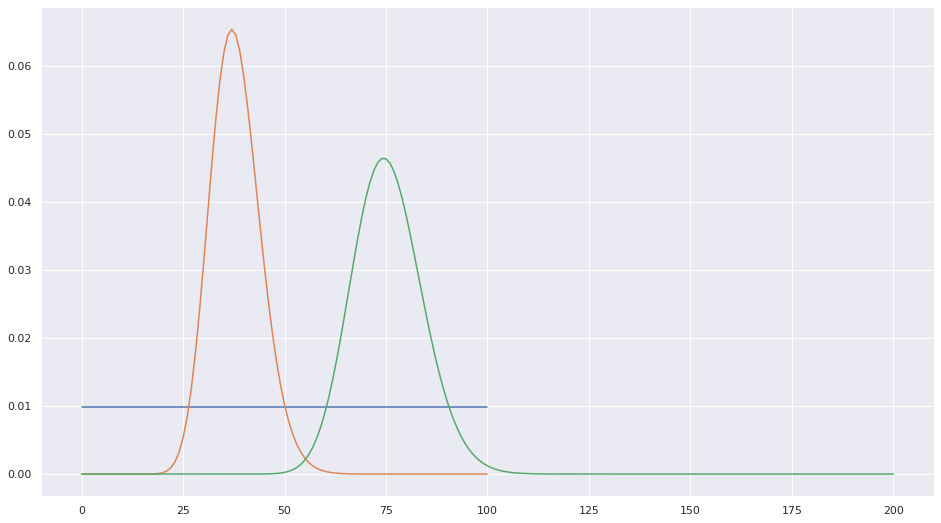

In [29]:
class CatchingFlies(thinkbayes2.Suite):
    def __init__(self, num_traps=100):
        super().__init__(self)
        for hypo in range(num_traps + 1):
            self.Set(hypo, 1)
        self.Normalize()
        self.num_traps = num_traps
    
    def Likelihood(self, data, hypo):
        return thinkbayes2.EvalPoissonPmf(data, hypo)
    
    def after_2_steps(self):
        after_2 = thinkbayes2.Pmf()
        for hypo1, prob1 in self.SortedItems():
            for hypo2, prob2 in self.SortedItems():
                after_2.Incr(hypo1 + hypo2, prob1 * (self.num_traps - hypo1) / self.num_traps * prob2)
        after_2.Normalize()
        return after_2

catching_flies = CatchingFlies()
sns.lineplot(*zip(*catching_flies.SortedItems()))

catching_flies.Update(37)
sns.lineplot(*zip(*catching_flies.SortedItems()))

after_2 = catching_flies.after_2_steps()
sns.lineplot(*zip(*after_2.SortedItems()))


# Exercise 7.4

From the exercise we know that we should use the Weibull distribution to model the number of failures that has the density function:

$ f(t; \lambda, k) = \frac k \lambda (\frac x \lambda )^{k - 1} \exp( - (\frac x \lambda)^k )  $ 

and since $\lambda$ is the scaling parameter we can set it to $1$. Our time unit is month in this case.

$ f(t; \lambda=1, k) = k x^{k - 1} \exp( - x^k )  $ 

So the probability density above model the time to failure for a single ligyht bulb.

So how do we start? 

We could define our hypotheses $ h \in \{0, 1, \dots, 100 \}$ to be the number of failed light bulbs. But how do we translate that into probabilities to fail at a certain point in time? Therefore we take the shape parameter $k > 1 $ to be the hypothese. We assume a uniform prior for $k$.

Then we need to deal with the likelihood update.

First we compute the failure probability for a given parameter $k$ according to this probability density function:

$ P(x; \lambda=1, k) = k x^{k - 1} \exp( - x^k) $

And we are interested in the probability that the failure happened within the first month $ x \leq 1 $.

$ P(F) = P(x \leq 1 month ) = 1 - \exp( - (\frac x \lambda)^k) $

The easiest approach would be to consider all month to be of the same length. We would take $ \lambda = 1$ and do the whole exercise in month. Unfortunately then the $ P(F) $ is constant for all different values of $k$, i.e. the posterior would be uniform as well.

Therefore we choose $\lambda = 30$  and we compute:

$ P(F) = P(x \leq \frac {31} {30} )$

Now we can use that as the p parameter in a Bernoulli distribution

$P(D=3 | h) = \binom{100}{3} P(F)^3 \cdot P(F)^{97} $

That should give us an estimation for the different $k$ values:

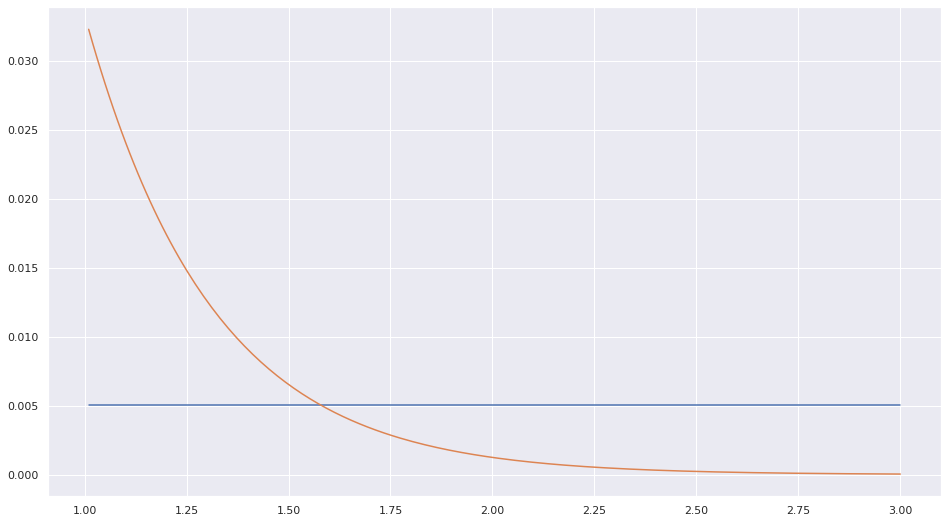

In [48]:
class WeibullShapeParameter(thinkbayes2.Suite):
    def __init__(self, upper_bound, num_bulbs, scaling_factor):
        super().__init__(self)
        for hypo in np.linspace(1.01, upper_bound, int((upper_bound - 1.01) * 100)):
            self.Set(hypo, 1)
        self.Normalize()
        self.num_bulbs = num_bulbs
        self.scaling_factor = scaling_factor
        
    def Likelihood(self, data, hypo):
        num_failures, time_interval = data
        p_fail = 1 - math.exp(-1. * (time_interval / self.scaling_factor) ** hypo)
        possibilities = scp.special.comb(N=self.num_bulbs, k=num_failures, exact=True)
        return possibilities * p_fail ** num_failures * (1 - p_fail) ** (self.num_bulbs - num_failures)
    
k_estimator = WeibullShapeParameter(
    upper_bound=3.,
    num_bulbs=100,
    scaling_factor=30.
)
sns.lineplot(*zip(*k_estimator.SortedItems()))
k_estimator.Update((3, 31))
sns.lineplot(*zip(*k_estimator.SortedItems()))


Above we see the distribution for all $k$ values. Now the only thing is to use them for coming up with an estimate for the number of failed bulbs.

So we are interested in 

$P( 1.2. < t < 1.4.) = P(31 < t < 90) = P(t < 90) - P ( t < 31 ) = \exp( - (\frac {31} \lambda)^k) - \exp( - ( \frac {90} \lambda )^k )$

for every value of $k$ to get the probability of a failure after the 1st of Februar. And then we interprete it as a bionomial distribution again.

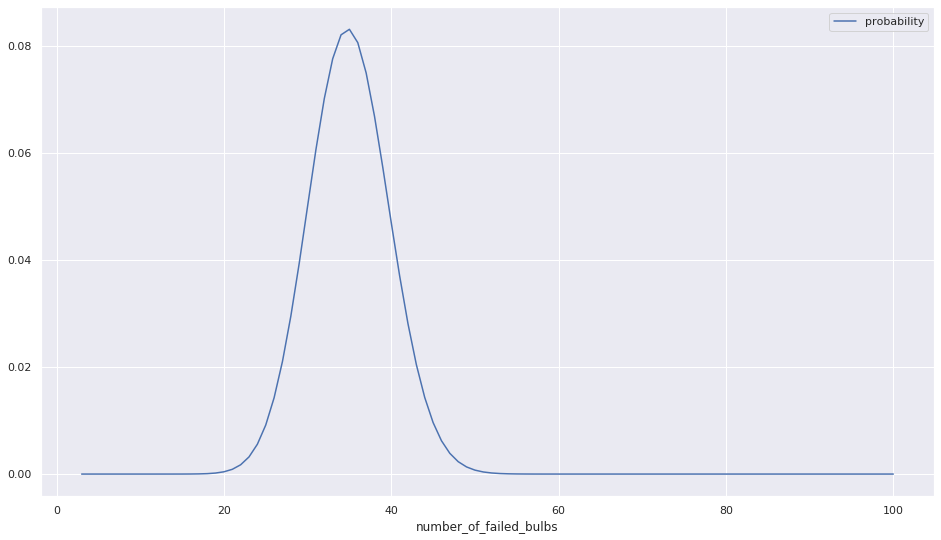

In [62]:
beginning, end = (31, 90)
remaining_bulbs = 97

meta_bulb_failures = thinkbayes2.Pmf()

for k, prob in k_estimator.SortedItems():
    p_future_fail = math.exp(-1. * (beginning / k_estimator.scaling_factor)** k) - math.exp(-1. * (end / k_estimator.scaling_factor)** k)
    meta_bulb_failures.Set(
        thinkbayes2.Pmf({
            num_fails + 3: (
                scp.special.comb(N=remaining_bulbs, k=num_fails, exact=True) 
                * p_future_fail ** num_fails 
                * (1 - p_future_fail) ** (remaining_bulbs - num_fails)
            )
            for num_fails in range(remaining_bulbs + 1)
        }),
        prob
    )
    
number_of_failed_bulbs = thinkbayes2.MakeMixture(meta_bulb_failures)
# number_of_failed_bulbs
sns.lineplot(
    data=pd.DataFrame(
        number_of_failed_bulbs.SortedItems(),
        columns=['number_of_failed_bulbs', 'probability']
    ).set_index('number_of_failed_bulbs')
)